In [1]:
!pip install -q wordninja pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Imports
!pip install -q transformers datasets evaluate scikit-learn pandas numpy matplotlib seaborn

import os
import re
import json
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
import wordninja
from datasets import Dataset
from datetime import datetime
import torch
from torch.nn import CrossEntropyLoss

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, label_ranking_average_precision_score, accuracy_score, ConfusionMatrixDisplay
from transformers import DebertaV2TokenizerFast, DebertaV2Model, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
# from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set output directory for results
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
output_dir = f"/content/drive/MyDrive/266_final_project_outputs/clean/deberta_model_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Load Data
data_dir = "drive/MyDrive/266_final_project/data"

# Load .tsv files
train_df = pd.read_csv("drive/MyDrive/266_final_project/data/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
valid_df = pd.read_csv("drive/MyDrive/266_final_project/data/dev.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
test_df = pd.read_csv("drive/MyDrive/266_final_project/data/test.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

# Load emotions list
with open(f"{data_dir}/emotions.txt", "r") as f:
    emotion_list = f.read().splitlines()

In [6]:
# Parse labels into lists of emotion names
def decode_labels(label_str):
    return [emotion_list[int(i)] for i in label_str.split(',')]

train_df['decoded'] = train_df['Class'].apply(decode_labels)
valid_df['decoded'] = valid_df['Class'].apply(decode_labels)
test_df['decoded'] = test_df['Class'].apply(decode_labels)

In [7]:
# Filter out 'neutral' and 'disgust'
EXCLUDED_LABELS = {'neutral', 'disgust'}

def filter_labels(row):
    return [e for e in row if e not in EXCLUDED_LABELS]

def remove_rows(df):
    df = df.copy()
    df['filtered'] = df['decoded'].apply(filter_labels)
    return df[df['filtered'].map(len) > 0]

train_df = remove_rows(train_df)
valid_df = remove_rows(valid_df)
test_df = remove_rows(test_df)

In [8]:
# Create new emotion set
ekman_labels_3 = sorted(list(set([e for row in train_df['filtered'] for e in row])))
label_to_idx = {label: i for i, label in enumerate(ekman_labels_3)}

In [9]:
def get_primary_from_filtered(filtered):
    if isinstance(filtered, list) and filtered:
        return label_to_idx[filtered[0]]
    return -1

# Assign primary label from first valid emotion
train_df['primary'] = train_df['filtered'].apply(get_primary_from_filtered)
valid_df['primary'] = valid_df['filtered'].apply(get_primary_from_filtered)
test_df['primary']  = test_df['filtered'].apply(get_primary_from_filtered)

# Drop rows with no valid primary label
train_df = train_df[train_df['primary'] != -1]
valid_df = valid_df[valid_df['primary'] != -1]
test_df  = test_df[test_df['primary'] != -1]

### Tokenization:

In [10]:
max_len = 128
# Updated to use DeBERTa tokenizer
tokenizer = DebertaV2TokenizerFast.from_pretrained("microsoft/deberta-v3-base")

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=max_len)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

In [11]:
# Create Dataset from train_df
train_ds = Dataset.from_pandas(train_df[['Text', 'primary']].copy())

# Rename columns
train_ds = train_ds.rename_column("Text", "text")
train_ds = train_ds.rename_column("primary", "labels")

# Tokenize and format for model
train_ds = train_ds.map(tokenize, batched=True)
train_ds = train_ds.with_format("torch")

Map:   0%|          | 0/30063 [00:00<?, ? examples/s]

In [12]:
val_ds = Dataset.from_pandas(valid_df[['Text', 'primary']].copy())
val_ds = val_ds.rename_column("Text", "text")
val_ds = val_ds.rename_column("primary", "labels")
val_ds = val_ds.map(tokenize, batched=True)
val_ds = val_ds.with_format("torch")

Map:   0%|          | 0/3772 [00:00<?, ? examples/s]

In [13]:
test_ds = Dataset.from_pandas(test_df[['Text', 'primary']].copy())
test_ds = test_ds.rename_column("Text", "text")
test_ds = test_ds.rename_column("primary", "labels")
test_ds = test_ds.map(tokenize, batched=True)
test_ds = test_ds.with_format("torch")

Map:   0%|          | 0/3744 [00:00<?, ? examples/s]

In [14]:
num_labels = len(label_to_idx)
# Updated to use DeBERTa model
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=num_labels
)

for param in model.parameters():
    param.requires_grad = True

# Resize token embeddings
model.resize_token_embeddings(len(tokenizer))

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(128001, 768, padding_idx=0)

In [15]:
# training_args = TrainingArguments(
#     output_dir="./checkpoints",
#     run_name="deberta_no_weights_run",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     logging_dir="./logs",
#     num_train_epochs=6,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     learning_rate=3e-5,  # Slightly lower learning rate for DeBERTa
#     lr_scheduler_type="cosine",
#     warmup_steps=500,  # Added warmup steps for better training stability
#     weight_decay=0.01,  # Added weight decay for regularization
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     report_to="none",
#     logging_strategy="epoch",
#     seed=42  # Added seed for reproducibility
# )

training_args = TrainingArguments(
    output_dir="./checkpoints_debertac",
    run_name="deberta_no_weights_run",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs_deberta",
    num_train_epochs=6,
    per_device_train_batch_size=8,  # Reduced batch size due to DeBERTa's larger memory footprint
    per_device_eval_batch_size=8,
    learning_rate=2e-5,  # Slightly lower learning rate for DeBERTa
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,  # Add warmup for DeBERTa
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    logging_strategy="epoch",
    gradient_accumulation_steps=2,  # To simulate larger batch size
    fp16=True  # Enable mixed precision training for efficiency
)

In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[]
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.072800,1.475805,0.587222
2,1.337800,1.379143,0.609756
3,1.096900,1.372922,0.611877
4,0.883600,1.404424,0.613203
5,0.722400,1.474961,0.616649
6,0.641300,1.489760,0.613468


TrainOutput(global_step=11274, training_loss=1.1257911832361795, metrics={'train_runtime': 3316.8962, 'train_samples_per_second': 54.382, 'train_steps_per_second': 3.399, 'total_flos': 1.1867630983769088e+16, 'train_loss': 1.1257911832361795, 'epoch': 6.0})

In [18]:
BEST_DIR = "/content/drive/MyDrive/266_final_project/clean/deberta_best_model"

# Save to Drive
trainer.save_model(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)

('/content/drive/MyDrive/266_final_project/clean/deberta_best_model/tokenizer_config.json',
 '/content/drive/MyDrive/266_final_project/clean/deberta_best_model/special_tokens_map.json',
 '/content/drive/MyDrive/266_final_project/clean/deberta_best_model/spm.model',
 '/content/drive/MyDrive/266_final_project/clean/deberta_best_model/added_tokens.json',
 '/content/drive/MyDrive/266_final_project/clean/deberta_best_model/tokenizer.json')

In [19]:
# Evaluate the model on validation or test set
eval_metrics = trainer.evaluate()

# Save metrics to Drive
with open(f"{BEST_DIR}/eval_metrics.json", "w") as f:
    json.dump(eval_metrics, f, indent=2)

In [20]:
# Get predictions on test set
preds = trainer.predict(test_ds)

y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Reverse label_to_idx to get string label names
idx_to_label = {v: k for k, v in label_to_idx.items()}
label_names = [idx_to_label[i] for i in range(len(idx_to_label))]

# Generate classification report
report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(2)

# Save full classification report
df_report.to_csv(f"{BEST_DIR}/emotion_classification_report.csv")

df_emotions = df_report.loc[label_names][["precision", "recall", "f1-score"]]
df_report

,precision,recall,f1-score,support
admiration,0.72,0.79,0.75,504.00
amusement,0.80,0.90,0.85,252.00
anger,0.59,0.61,0.60,197.00
annoyance,0.45,0.37,0.41,286.00
approval,0.55,0.55,0.55,318.00
caring,0.52,0.54,0.53,114.00
confusion,0.51,0.51,0.51,139.00
curiosity,0.59,0.67,0.63,233.00
desire,0.81,0.57,0.67,74.00
disappointment,0.41,0.36,0.39,127.00


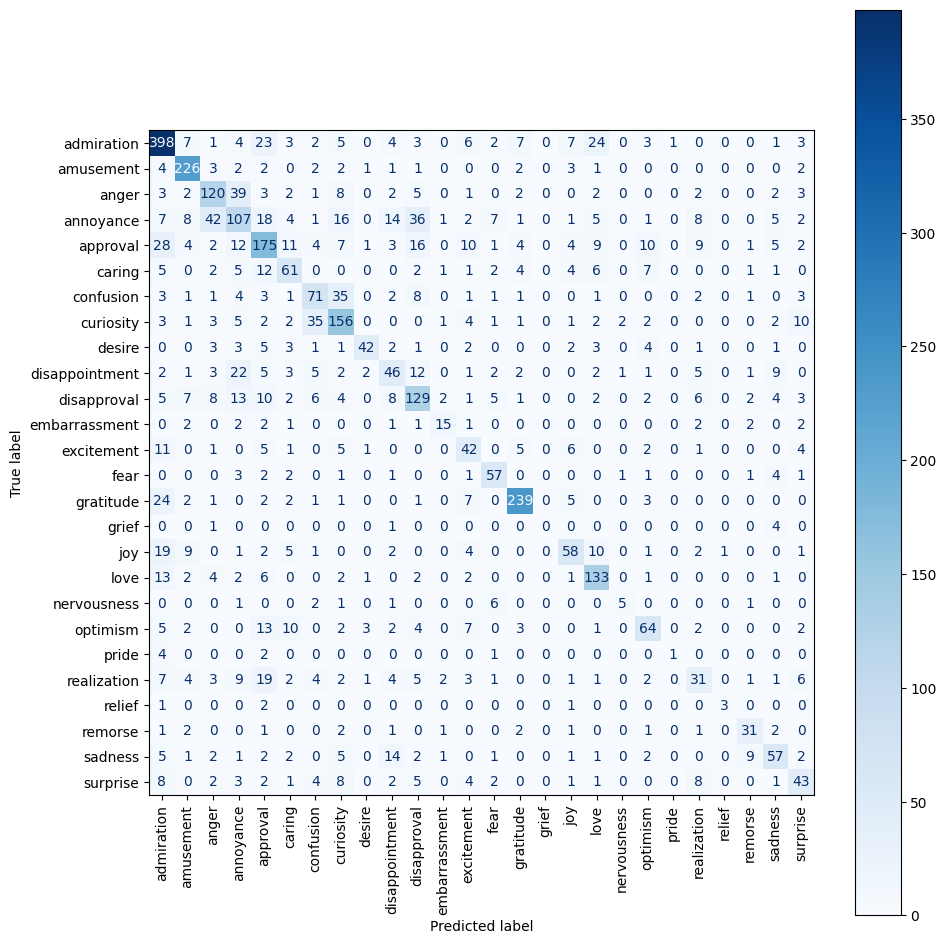

In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Save matrix as image
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/confusion_matrix.png")

# Save matrix as CSV
pd.DataFrame(cm, index=label_names, columns=label_names).to_csv(f"{BEST_DIR}/confusion_matrix.csv")

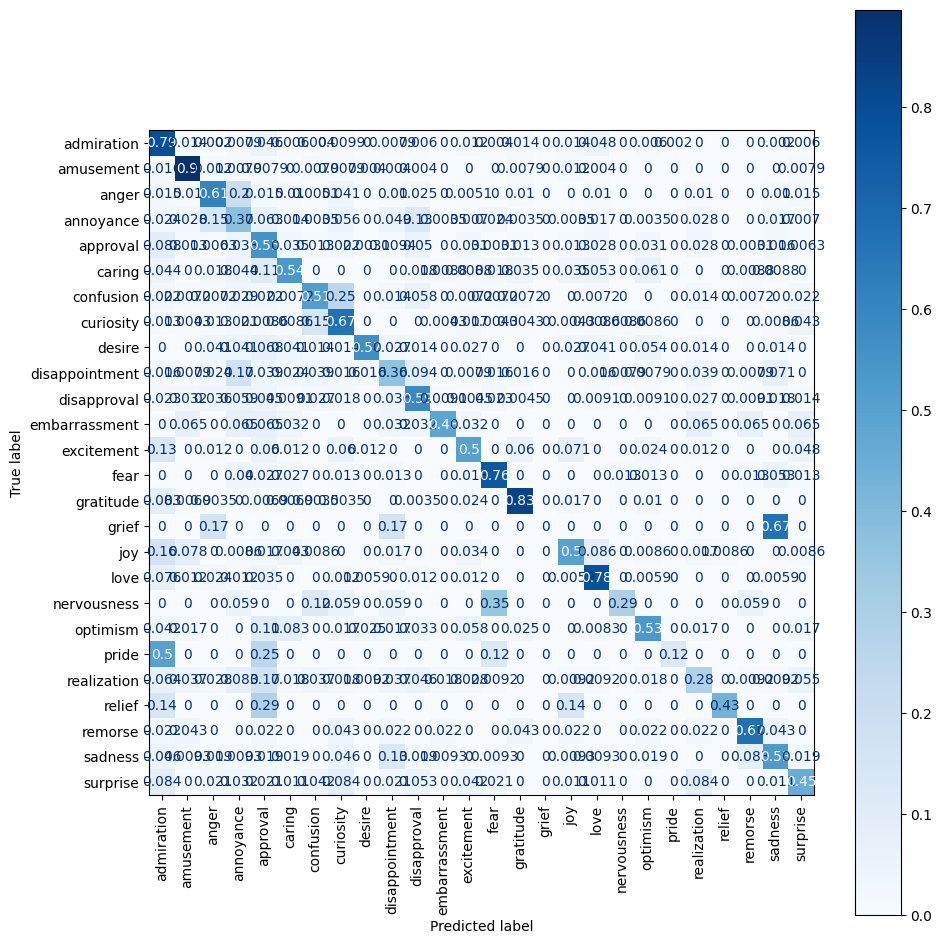

In [22]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Save matrix as image
disp = ConfusionMatrixDisplay(cm_normalized, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/confusion_matrix_normalized.png")

# Save matrix as CSV
pd.DataFrame(cm_normalized, index=label_names, columns=label_names).to_csv(f"{BEST_DIR}/confusion_matrix_normalized.csv")

In [23]:
df_report = df_report.rename_axis("Emotion").reset_index()
df_emotions = df_report[~df_report["Emotion"].str.contains("avg|accuracy|std", case=False, na=False)].copy()

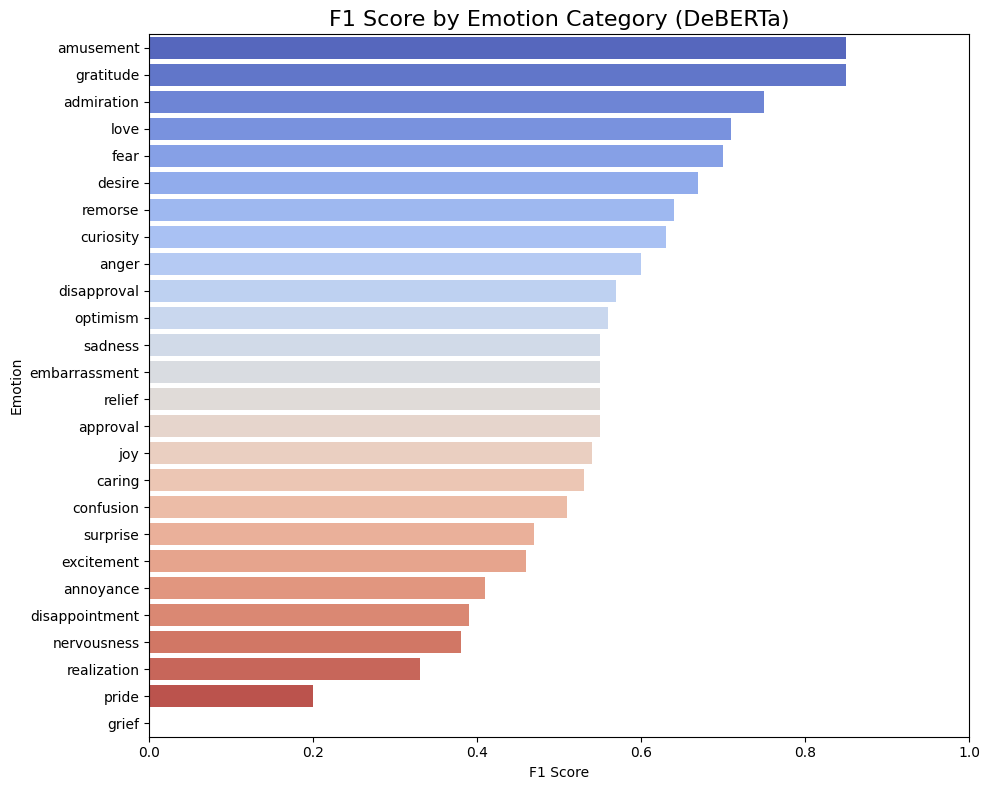

In [24]:
# Sort by F1
df_sorted = df_emotions.sort_values("f1-score", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_sorted, x="f1-score", y="Emotion", palette="coolwarm")
plt.title("F1 Score by Emotion Category (DeBERTa)", fontsize=16)
plt.xlabel("F1 Score")
plt.ylabel("Emotion")
plt.xlim(0, 1)
plt.tight_layout()

plt.savefig(f"{BEST_DIR}/emotion_f1_scores_paper_style.pdf")
plt.savefig(f"{BEST_DIR}/emotion_f1_scores_paper_style.png")
plt.show()

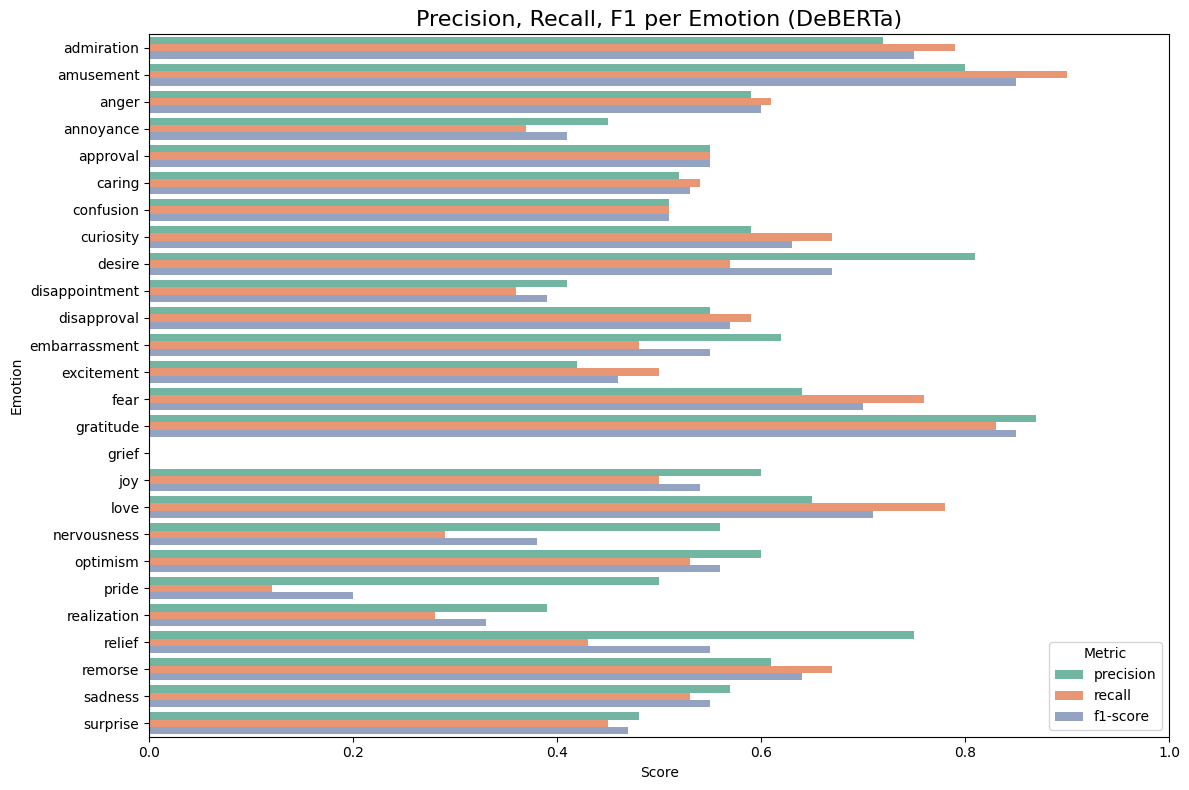

In [25]:
df_melted = df_emotions[["Emotion", "precision", "recall", "f1-score"]].melt(
    id_vars="Emotion", var_name="Metric", value_name="Score"
)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_melted, x="Score", y="Emotion", hue="Metric", palette="Set2")
plt.title("Precision, Recall, F1 per Emotion (DeBERTa)", fontsize=16)
plt.xlabel("Score")
plt.ylabel("Emotion")
plt.xlim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()

plt.savefig(f"{BEST_DIR}/figure_2_grouped_metrics_per_emotion.pdf")
plt.savefig(f"{BEST_DIR}/figure_2_grouped_metrics_per_emotion.png")
plt.show()

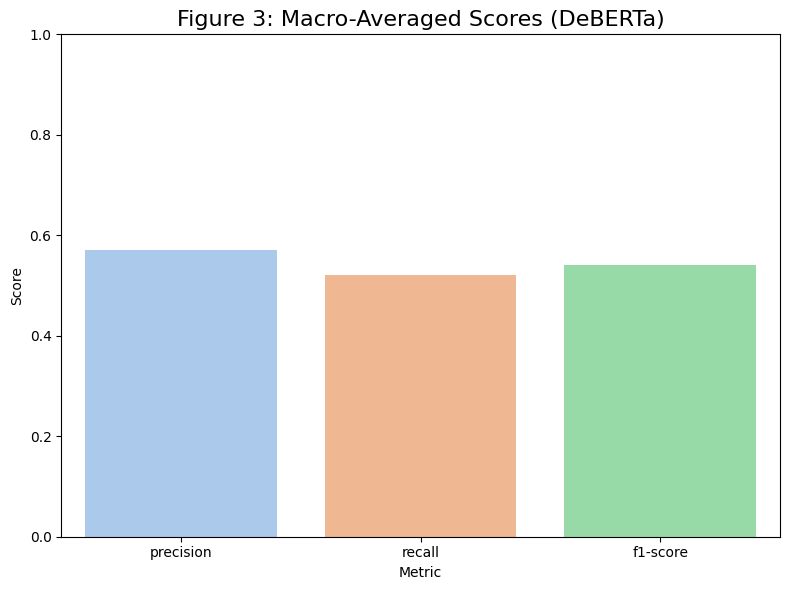

In [26]:
macro_avg = df_report[df_report["Emotion"] == "macro avg"]
macro_df = macro_avg[["precision", "recall", "f1-score"]].melt(
    var_name="Metric", value_name="Score"
)

plt.figure(figsize=(8, 6))
sns.barplot(data=macro_df, x="Metric", y="Score", palette="pastel")
plt.title("Figure 3: Macro-Averaged Scores (DeBERTa)", fontsize=16)
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig(f"{BEST_DIR}/figure_3_macro_avg_scores.pdf")
plt.savefig(f"{BEST_DIR}/figure_3_macro_avg_scores.png")
macro_df.to_csv(f"{BEST_DIR}/figure_3_macro_avg_scores.csv", index=False)
plt.show()

In [27]:
df_support = df_emotions[["Emotion", "support"]].sort_values("support", ascending=False)
df_support.to_csv(f"{BEST_DIR}/emotion_support_counts.csv", index=False)

In [28]:
cm = confusion_matrix(y_true, y_pred)
conf_df = pd.DataFrame(cm, index=label_names, columns=label_names)
conf_df.to_csv(f"{BEST_DIR}/confusion_matrix_raw.csv")

# Top 10 most confused
np.fill_diagonal(cm, 0)
top_confused = sorted(
    [(label_names[i], label_names[j], cm[i, j])
     for i in range(len(cm)) for j in range(len(cm)) if cm[i, j] > 0],
    key=lambda x: -x[2]
)[:10]

print("Top 10 most confused pairs:")
for a, b, count in top_confused:
    print(f"{a} ↔ {b}: {count} times")

Top 10 most confused pairs:
annoyance ↔ anger: 42 times
anger ↔ annoyance: 39 times
annoyance ↔ disapproval: 36 times
confusion ↔ curiosity: 35 times
curiosity ↔ confusion: 35 times
approval ↔ admiration: 28 times
admiration ↔ love: 24 times
gratitude ↔ admiration: 24 times
admiration ↔ approval: 23 times
disappointment ↔ annoyance: 22 times
